# View examples of phone segmentation results

Copyright (c) 2020 Herman Kamper, MIT License.

## Preliminaries

In [1]:
%matplotlib inline
from pathlib import Path
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
import numpy as np
import pylab as plt
import sys

sys.path.append("..")

from eval_segmentation import boundaries_to_intervals, intervals_to_boundaries, score_boundaries, get_os, get_rvalue, get_intervals_from_dir

## Read spectrograms, codes, segmentation

In [2]:
# Dataset
dataset = "buckeye"
split = "val"
model = "vqcpc"
phoneseg_tag = "phoneseg_l2"

# Dataset
dataset = "buckeye"
split = "val"
model = "vqvae"
phoneseg_tag = "phoneseg_l2.4"

# Utterances
utterances = [
    "s22_02b_027666-027761",
    "s17_01a_001056-001166",
    "s17_01a_005537-005624",
#     "s17_01a_008913-009046",
#     "s17_01a_001935-002053",
    ]

# Directories
indices_dir = Path("../exp/")/model/dataset/split/"indices"
z_dir = Path("../exp/")/model/dataset/split/"auxiliary_embedding2"
phoneseg_dir = Path("../exp/")/model/dataset/split/phoneseg_tag/"intervals"
phoneref_dir = Path("../data/")/dataset/"phone_intervals"
audio_dir = Path("../../VectorQuantizedCPC/datasets/")/dataset/split

In [3]:
# Read indices
indices_dict = {}
for utterance_key in sorted(utterances):
    indices_fn = (indices_dir/utterance_key).with_suffix(".txt")
    indices_dict[utterance_key] = np.asarray(np.loadtxt(indices_fn), dtype=int)

# Read pre-quantisation
z_dict = {}
for utterance_key in sorted(utterances):
    z_fn = (z_dir/utterance_key).with_suffix(".txt")
    z_dict[utterance_key] = np.loadtxt(z_fn)

# Audio
audio_dict = {}
for utterance_key in sorted(utterances):
    fn = (audio_dir/utterance_key.split("_")[0]/utterance_key).with_suffix(".mel.npy")
    audio_dict[utterance_key] = np.load(fn).T
    
# Read segmentation
segmentation_interval_dict = {}
for utterance_key in sorted(utterances):
    segmentation_interval_dict[utterance_key] = []
    fn = (phoneseg_dir/utterance_key).with_suffix(".txt")
    for start, end, label in [i.split() for i in fn.read_text().strip().split("\n")]:
        start = int(start)
        end = int(end)
        label = int(label)
        segmentation_interval_dict[utterance_key].append((start, end, label))
    
# Read reference
reference_interval_dict = {}
for utterance_key in sorted(utterances):
    reference_interval_dict[utterance_key] = []
    fn = (phoneref_dir/utterance_key).with_suffix(".txt")
    for start, end, label in [i.split() for i in fn.read_text().strip().split("\n")]:
        start = int(start)
        end = int(end)
        reference_interval_dict[utterance_key].append((start, end, label))

## Convert intervals to boundaries

In [4]:
segmentation_boundaries_dict = {}
for utterance_key in segmentation_interval_dict:
    segmentation_boundaries_dict[utterance_key] = intervals_to_boundaries(
        segmentation_interval_dict[utterance_key]
        )

reference_boundaries_dict = {}
for utterance_key in reference_interval_dict:
    reference_boundaries_dict[utterance_key] = intervals_to_boundaries(
        reference_interval_dict[utterance_key]
        )

## Plot codes, reference, segmentation on top of spectrograms

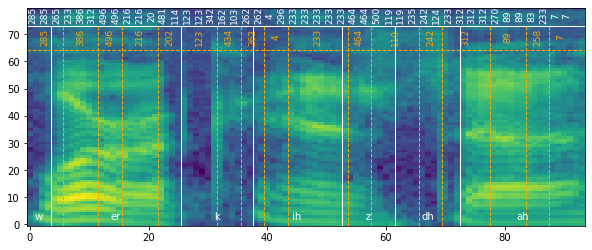

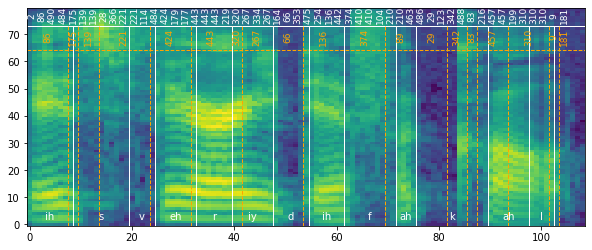

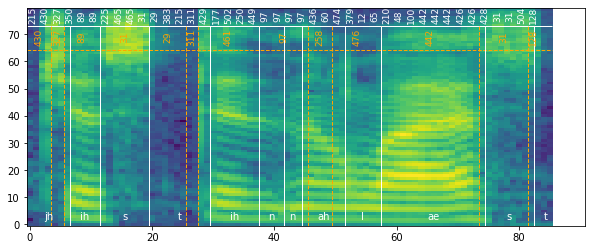

In [5]:
# for utterance_key in utterances[:1]:
for utterance_key in utterances:
    features = audio_dict[utterance_key].T
    indices = indices_dict[utterance_key]
    phones = reference_interval_dict[utterance_key]

    # Codes
    plt.figure(figsize=(10, 4))
    plt.imshow(features, origin="bottom", aspect="auto", interpolation="nearest")
    for i in range(len(indices)):
        plt.text(i*2 + 0.5, features.shape[0] - 3, str(indices[i]), color="w", va="center", ha="center", rotation=90, size=9)
    plt.hlines(features.shape[0] - 7, -0.5, features.shape[1] - 0.5, colors="w", lw=1)
    
    # Segmentation
    c = "orange"
    for start, end, label in segmentation_interval_dict[utterance_key]:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, features.shape[0] - 11, label, color=c, va="center", ha="center", rotation=90, size=9)
    plt.vlines(
        np.where(segmentation_boundaries_dict[utterance_key][:-1])[0] + 0.5, ymin=-0.5, ymax=features.shape[0] - 7, colors=c, lw=1, linestyles="dashed"
        )  # predicted boundaries
    plt.hlines(features.shape[0] - 16, -0.5, features.shape[1] - 0.5, colors=c, lw=1, linestyles="dashed")
    
    # Reference
    for start, end, label in phones:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, 3, label, color="w", va="center", ha="center")
    plt.vlines(
        np.where(reference_boundaries_dict[utterance_key])[0] + 0.5, ymin=-0.5, ymax=73, colors="w", lw=1
        )  # reference boundaries

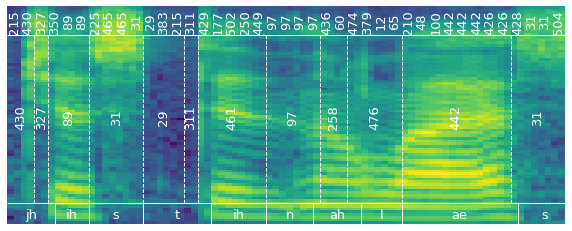

In [16]:
# Plot for paper

# for utterance_key in utterances[:1]:
for utterance_key in utterances[-1:]:
    features = audio_dict[utterance_key].T
    indices = indices_dict[utterance_key]
    phones = reference_interval_dict[utterance_key]
    phones = phones.copy()
    phones[5] = (38, 45, "n")
    phones.pop(6)
#     print(phones[5])  # (38, 42, 'n'), (42, 45, 'n')
#     print(np.where(reference_boundaries_dict[utterance_key]))
    reference_boundaries_dict[utterance_key][41] = False

    size = 13  # size
#     max_x = 81.5
    
    # Codes
    c = "w"
    plt.figure(figsize=(10, 4))
    plt.imshow(features, origin="bottom", aspect="auto", interpolation="nearest", alpha=1.0)
    for i in range(len(indices))[:-1]:
        plt.text(i*2 + 0.5, 74, str(indices[i]), color=c, va="center", ha="center", rotation=90, size=size)
    plt.hlines(69, -0.5, features.shape[1] - 0.5, colors=c, lw=1)

    # Reference
    for start, end, label in phones[:-1]:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, 3, label, color=c, va="center", ha="center", size=size)
    plt.vlines(
        np.where(reference_boundaries_dict[utterance_key])[0] + 0.5, ymin=-0.5, ymax=7, colors=c, lw=1
        )  # reference boundaries
    plt.hlines(7, -0.5, features.shape[1] - 0.5, colors=c, lw=1)
    
    # Segmentation
    c = "w"
    for start, end, label in segmentation_interval_dict[utterance_key][:-1]:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, 39, label, color=c, va="center", ha="center", rotation=90, size=size)
    plt.vlines(
        np.where(segmentation_boundaries_dict[utterance_key][:-1])[0] + 0.5, ymin=7, ymax=69, colors=c, lw=1, linestyles="dashed"
        )  # predicted boundaries
#     plt.hlines(features.shape[0] - 17, -0.5, features.shape[1] - 0.5, colors=c, lw=1, linestyles="dashed")
    
    
    plt.axis("off")
    plt.xlim([-0.5, 81.5])
    plt.savefig("just_in_the_last.pdf")

In [17]:
! pdfcrop just_in_the_last.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `just_in_the_last-crop.pdf'.


## Segmentation evaluation

In [19]:
# Evaluate phone boundaries
reference_list = []
segmentation_list = []
for utterance_key in utterances:
    reference_list.append(reference_boundaries_dict[utterance_key])
    segmentation_list.append(segmentation_boundaries_dict[utterance_key])
p, r, f = score_boundaries(reference_list, segmentation_list, tolerance=2)
print("Phone boundaries:")
print("Precision: {:.2f}%".format(p*100))
print("Recall: {:.2f}%".format(r*100))
print("F-score: {:.2f}%".format(f*100))
print("OS: {:.2f}%".format(get_os(p, r)*100))
print("R-value: {:.2f}%".format(get_rvalue(p, r)*100))

Phone boundaries:
Precision: 48.48%
Recall: 84.21%
F-score: 61.54%
OS: 73.68%
R-value: 30.69%
